# Проект по распознаванию рукописных цифр из набора данных MNIST с помощью Keras

In [1]:
from tensorflow.keras.datasets import mnist #Библиотека с базой Mnist
from tensorflow.keras.models import Sequential #НС прямого распространения
from tensorflow.keras.layers import Dense #Полносвязные слой
from tensorflow.keras import utils #Утилиты для to_categorical
from tensorflow.keras.preprocessing import image #Для отрисовки изображения
from google.colab import files #Для загрузки своей картинки
import numpy as np #Библиотека работы с массивами
import matplotlib.pyplot as plt #Отрисовка изображений
from PIL import Image #Отрисовка изображений
#Отрисовывать изображения в ноутбуке, а не в консоль или файл
%matplotlib inline 

## Подготовка данных для обучения сети

**Загрузка набора данных с рукописными цифрами**

In [2]:
#Загрузка данных Mnist
#x_train_org - входные картинки, обучающая выбрка
#y_train_org - выходные индексы, обучающая выборка
#x_test_org - входные картинки, тестовая выбрка
#y_test_org - выходные индексы, тестовая выборка
(x_train_org, y_train_org), (x_test_org, y_test_org) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


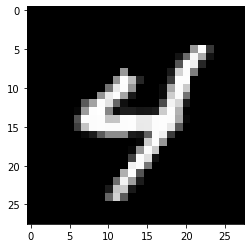

4


In [3]:
#Отрисовка картинки
n = 115 #Номер изображения из датасета
plt.imshow(Image.fromarray(x_train_org[n]).convert('RGBA'))
plt.show()
print(y_train_org[n])

**Преобразование размерности данных в наборе**

In [4]:
#Для удобства работы с полносвязным слоем (Dense) 
#меняем формат входных картинок с 28х28 на 784х1
x_train = x_train_org.reshape(60000, 784)
x_test = x_test_org.reshape(10000, 784)
print(x_train_org.shape)
print(x_train.shape)

(60000, 28, 28)
(60000, 784)


**Нормализация данных**

In [5]:
#Нормализуем входные картинки
#НС лучше работают, если данные нормаваны от 0 до 1
#Сейчас значения во входных картинках от 0 до 255
#Надо разделить картинки на 255
#И сначала преобразовать картинки в тип float
x_train = x_train.astype('float32')
x_train = x_train / 255
x_test = x_test.astype('float32')
x_test = x_test / 255 

**Преобразуем метки в формат one hot encoding**

In [6]:
#НС сложно работать с чистыми индексами от 0 до 9
#Ей проще работать с данными в формате one hot encoding
#Это формат из 10 цифр - все 0 и одна 1 там, где правильный ответ
#Например
#Индекс 0 - это [1 0 0 0 0 0 0 0 0 0]
#Индекс 2 - это [0 0 1 0 0 0 0 0 0 0]
#Индекс 9 - это [0 0 0 0 0 0 0 0 0 1]
#Это делается функцией utils.to_categorical()
#Второй параметр - это количество классов, у нас - 10
y_train = utils.to_categorical(y_train_org, 10)
y_test = utils.to_categorical(y_test_org, 10)

**Правильный ответ в формате one hot encoding**



In [7]:
#Выводим размер y_train
#60 тысяч примеров, каждый размера 10 (так как 10 классов)
print(y_train.shape)

(60000, 10)


In [8]:
#Выводим пример одного выходного вектора
print(y_train[n])

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


## Создаем нейронную сеть

**Создаем последовательную модель**

In [9]:
#Создаём сеть прямого распространения
#Пока она пустая
#Подробнее на https://keras.io/models/sequential/
model = Sequential()

**Добавляем уровни сети**


In [10]:
#Добавляем в сеть полносвязные слои
#Dense - полносвязный слой, подробнее на https://keras.io/layers/core/
#Первый параметр - количество нейронов, обычно от 2 до 2000, подбирается в ходе исследования
#input_dim - размер входного вектора, указывается только в первом слое сети
#activation - активационная функция нейронов данного слоя
#relu - одна из активационных функций, подробнее на https://keras.io/activations/
model.add(Dense(800, input_dim=784, activation="relu"))
model.add(Dense(400, activation="relu"))

#Выходной полносвязный слой, 10 нейронов (по количеству рукописных цифр)
#activation="softmax" - активационная функция, 
#которая делает сумму всех значений нейронов слой, равной 1
#Подробнее https://keras.io/activations/
model.add(Dense(10, activation="softmax"))

**Компилируем сеть**

In [11]:
#При компиляции мы задаём несколько параметров
#loss - функция ошибки, которую оптимизирует сеть
#categorical_crossentropy - одна из функций ошибки, подходящая для классификации нескольких классов, подробнее https://keras.io/activations/
#optimizer - алгоритм обучения НС
#adam - один из алгоритмов обучения НС, подробнее https://keras.io/optimizers/
#metrics - метрика качества обучения, измеряется после каждой эпохи обучения
#accuracy - метрика, процент правильно распознанных примеров, подробнее https://keras.io/metrics/
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

#Вывод структуры нейронки
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 800)               628000    
_________________________________________________________________
dense_1 (Dense)              (None, 400)               320400    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                4010      
Total params: 952,410
Trainable params: 952,410
Non-trainable params: 0
_________________________________________________________________
None


## Обучаем нейронную сеть

In [12]:
#fit - функция обучения нейронки
#x_train, y_train - обучающая выборка, входные и выходные данные
#batch_size - размер батча, количество примеров, которое обрабатывает нейронка, перед одним изменением весов
#epochs - количество эпох, когда нейронка обучается на всех примерах выбрки
#verbose - 0 - не визуализировать ход обучения, 1 - визуализировать
#validation_split - процент данных, на которых сеть не обучается, на которых мы измеряем точность распознавания
model.fit(x_train, y_train, batch_size=128, epochs=30, verbose=1, validation_split=0.2)

Epoch 1/30
375/375 [==============================] - 3s 4ms/step - loss: 0.4212 - accuracy: 0.8771 - val_loss: 0.1091 - val_accuracy: 0.9673
Epoch 2/30
375/375 [==============================] - 1s 3ms/step - loss: 0.0838 - accuracy: 0.9739 - val_loss: 0.0829 - val_accuracy: 0.9753
Epoch 3/30
375/375 [==============================] - 1s 3ms/step - loss: 0.0482 - accuracy: 0.9850 - val_loss: 0.0833 - val_accuracy: 0.9752
Epoch 4/30
375/375 [==============================] - 1s 3ms/step - loss: 0.0333 - accuracy: 0.9901 - val_loss: 0.0933 - val_accuracy: 0.9746
Epoch 5/30
375/375 [==============================] - 1s 3ms/step - loss: 0.0255 - accuracy: 0.9914 - val_loss: 0.0964 - val_accuracy: 0.9723
Epoch 6/30
375/375 [==============================] - 1s 3ms/step - loss: 0.0177 - accuracy: 0.9941 - val_loss: 0.0880 - val_accuracy: 0.9769
Epoch 7/30
375/375 [==============================] - 1s 3ms/step - loss: 0.0159 - accuracy: 0.9945 - val_loss: 0.0915 - val_accuracy: 0.9772
Epoch 

## Сохраняем обученную нейронную сеть

Записываем обученную нейронную сеть в файл `mnist_dense.h5`

In [15]:
#Сохраняем нейронку в файл
model.save("mnist_dense.h5")


Проверяем, что файл сохранился

**Сохраняем файлы на локальный компьютер**

In [14]:
#Скачиваем файл локально на компьютер
files.download("mnist_dense.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Используем сеть для распознавания рукописных цифр тестовой выборки

In [16]:
#Номер тестовой цифры, которую будем распознавать
n_rec = 2021

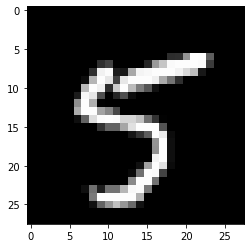

In [18]:
plt.imshow(Image.fromarray(x_test_org[n_rec]).convert('RGBA'))
plt.show()

**Меняем размерность изображения и нормализуем его**

In [19]:
#Выбираем нужную картинку из тестовой выборки
x = x_test[n_rec]
#Добавляем одну размерность в конце, чтобы нейронка могла распознать пример
#Потому что нейронка принимает именно массов примеров для распознавания
#Мы делаем массив из одного примеры
x = np.expand_dims(x, axis=0)

**Запускаем распознавание**

In [20]:
#Распознаём ннаш пример
prediction = model.predict(x)

**Печатаем результаты распознавания**

In [21]:
#Выводим результат, это 10 цифр
#Сумма значений равна 1, так как финальный слой с активационной функций softmax
print(prediction)

[[7.9839965e-21 1.4762439e-20 2.4132086e-25 1.1420310e-12 1.2410873e-23
  1.0000000e+00 1.6365444e-17 1.3426351e-18 5.0342250e-13 3.7920049e-12]]


**Преобразуем результаты из формата one hot encoding**

In [22]:
#Получаем индекс самого большого элемента
#Это итоговая цифра, которую распознала сеть
prediction = np.argmax(prediction)
print(prediction)

5


**Печатаем правильный ответ**

In [23]:
#выводим правильный ответ, для сравнения
print(y_test_org[n_rec])

5


## Проверяем нейросеть на тестовой выборке


In [25]:
y_test_predict = np.argmax(model.predict(x_test), axis=1)
y_test_prop = y_test_predict == y_test_org
print('Количество верных ответов:',sum(y_test_prop)/len(y_test_prop)*100,'%')

Количество верных ответов: 98.28 %


In [26]:
# анализируем правильность разпознавания каждого класса
cl_count = [0 for i in range(10)]
cl_prop = [0 for i in range(10)]
for i in range(len(y_test_org)):
  cl_count[y_test_org[i]] += 1
  if y_test_prop[i]:
    cl_prop[y_test_org[i]] += 1
for i in range(len(cl_count)):
  print(i, ': ', round(cl_prop[i]/cl_count[i]*100,2),'%')

0 :  99.08 %
1 :  99.38 %
2 :  98.35 %
3 :  98.12 %
4 :  97.86 %
5 :  98.09 %
6 :  99.06 %
7 :  98.44 %
8 :  97.84 %
9 :  96.43 %


In [27]:
import operator
# анализируем характерные ошибки каждого класса
cl_err_count = [0 for i in range(10)]
cl_err_dict = [{} for i in range(10)]
for i in range(len(y_test_org)):
  if not y_test_prop[i]:
    cl_err_count[y_test_org[i]] += 1
    if y_test_predict[i] not in cl_err_dict[y_test_org[i]]:
      cl_err_dict[y_test_org[i]][y_test_predict[i]] = 1
    else:
      cl_err_dict[y_test_org[i]][y_test_predict[i]] += 1

for i in range(len(cl_err_count)):
  print(i, ': ', end='')
  cl_err_dict[i] = dict(sorted(cl_err_dict[i].items(), key=operator.itemgetter(1), reverse = True))
  for key in cl_err_dict[i].keys():
    print(key,' - ', round(cl_err_dict[i][key]/cl_err_count[i]*100,2),'%, ',sep='', end='')
  print()
  #print(i, ': ', round(cl_prop[i]/cl_count[i]*100,2),'%')

0 : 6 - 44.44%, 2 - 22.22%, 8 - 11.11%, 7 - 11.11%, 1 - 11.11%, 
1 : 8 - 42.86%, 6 - 42.86%, 5 - 14.29%, 
2 : 7 - 29.41%, 0 - 23.53%, 8 - 23.53%, 3 - 11.76%, 4 - 5.88%, 1 - 5.88%, 
3 : 2 - 31.58%, 5 - 26.32%, 7 - 15.79%, 8 - 10.53%, 0 - 10.53%, 9 - 5.26%, 
4 : 9 - 33.33%, 2 - 19.05%, 6 - 14.29%, 7 - 14.29%, 0 - 9.52%, 5 - 4.76%, 1 - 4.76%, 
5 : 3 - 35.29%, 6 - 17.65%, 8 - 17.65%, 0 - 11.76%, 4 - 5.88%, 7 - 5.88%, 9 - 5.88%, 
6 : 5 - 44.44%, 0 - 22.22%, 1 - 22.22%, 4 - 11.11%, 
7 : 2 - 50.0%, 8 - 25.0%, 3 - 12.5%, 9 - 6.25%, 0 - 6.25%, 
8 : 3 - 23.81%, 2 - 14.29%, 9 - 14.29%, 7 - 14.29%, 4 - 9.52%, 6 - 9.52%, 5 - 9.52%, 0 - 4.76%, 
9 : 4 - 25.0%, 5 - 16.67%, 7 - 16.67%, 3 - 16.67%, 0 - 11.11%, 8 - 8.33%, 1 - 5.56%, 


## Загружаем свою картинку

In [36]:
#Загрузка файла со своей рукописной цифрой
files.upload()

Saving 007.jpg to 007.jpg


{'007.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x02\x01\x01\x02\x02\x02\x02\x02\x02\x02\x02\x03\x05\x03\x03\x03\x03\x03\x06\x04\x04\x03\x05\x07\x06\x07\x07\x07\x06\x07\x07\x08\t\x0b\t\x08\x08\n\x08\x07\x07\n\r\n\n\x0b\x0c\x0c\x0c\x0c\x07\t\x0e\x0f\r\x0c\x0e\x0b\x0c\x0c\x0c\xff\xdb\x00C\x01\x02\x02\x02\x03\x03\x03\x06\x03\x03\x06\x0c\x08\x07\x08\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\xff\xc0\x00\x11\x08\x00u\x00l\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\

Проверяем загрузку картинки

In [37]:
!ls

 004.jpg   007.jpg  'mnist_dense (1).h5'   mnist_dense.h5   sample_data


Загружаем картинку из файла

In [38]:
#Указывает путь к файлу
img_path = '007.jpg'
#Загружаем картинку, меняем размер на 28х28, формат на оттенки серого
img = image.load_img(img_path, target_size=(28, 28), color_mode = "grayscale")

Показываем картинку

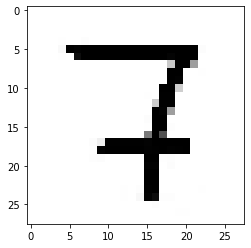

In [39]:
#Вывод картинки
plt.imshow(img.convert('RGBA'))
plt.show()

Преобразуем картинку для обработки нейронной сетью

In [40]:
#Преобразуем картинку в массив
x = image.img_to_array(img)
#Меняем форму массива в плоский вектор
x = x.reshape(1, 784)
#Инвертируем изображение, нам надо белое на чёрном фоне
x = 255 - x
#Нормализуем изображение
x /= 255

Запускаем распознавание

In [41]:
#Распознаём картинку
prediction = model.predict(x)

Результаты распознавания

In [42]:
#Выводим результат
prediction

array([[4.5533240e-18, 3.1681657e-06, 4.7299691e-05, 1.4480938e-06,
        2.7658658e-09, 5.8493730e-14, 4.7525579e-15, 9.9994802e-01,
        6.7219572e-12, 6.9157319e-12]], dtype=float32)

In [43]:
#Вывод распознанной цифры
print(np.argmax(prediction))

7
